##1-İMPORT LİBRARİES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

##2-BUİLD FUNCTIONS

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

##3-DATA CREATE VALUES

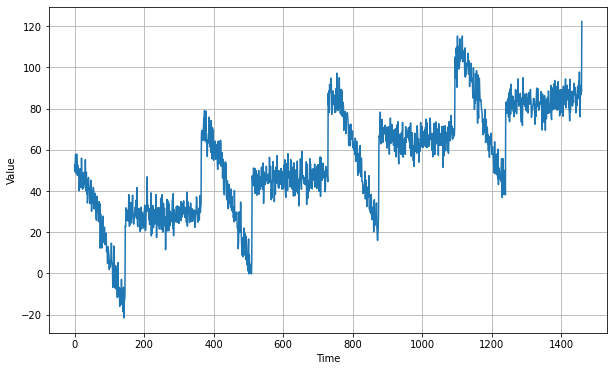

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

##4-TRAİN-VALİD SET TİME

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

##5-PREPROCESSİNG WİTH 1D-CONVOLUTİONAL LAYERS

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(1e-08, 0.0001, 0.0, 30.0)

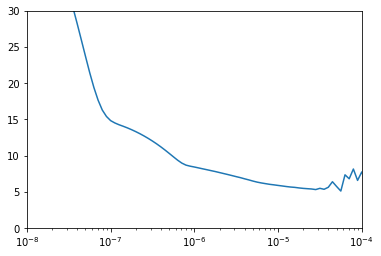

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 8ms/step


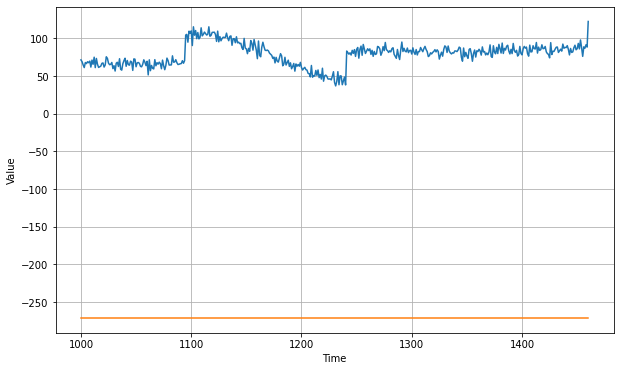

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

#Full Convolutional Forecast

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(0.0001, 0.1, 0.0, 30.0)

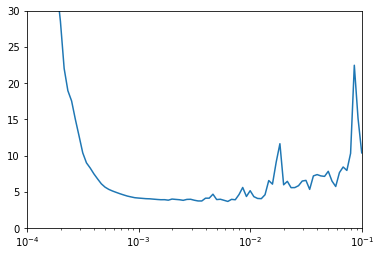

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size =128)
valid_set = seq2seq_window_dataset(x_valid,window_size , batch_size = 128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [None,1]))

for dilation_rate in (1,2,4,8,16,32):
  model.add(
      keras.layers.Conv1D(
          filters = 32,
          kernel_size = 2,
          strides= 1,
          dilation_rate = dilation_rate,
          padding = "causal",
          activation = "relu"

      )
  )

model.add(keras.layers.Conv1D(filters = 1,kernel_size = 1))

optimizer = keras.optimizers.Adam(lr = 3e-4)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5",save_best_only = True
)

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

history = model.fit(train_set,epochs = 500,
                    validation_data = valid_set,
                    callbacks = [early_stopping,model_checkpoint])


In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 8ms/step


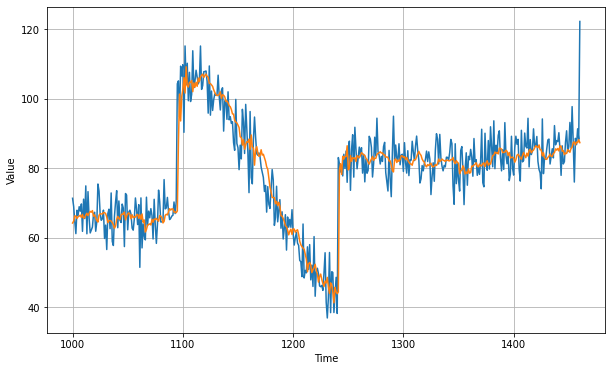

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.568056

# PREDİCT TRY CNN ISDEMİR

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
start = "2019-01-01"
end = "2023-01-01"
symbol = "ISDMR.IS"
df = yf.Ticker(symbol)
df = df.history(start=start , end=end)
[['Open','High','Low','Close']]

[['Open', 'High', 'Low', 'Close']]

In [ ]:
df["Date"] = df.index


In [ ]:
graph = df["Close"]


In [ ]:
type(graph)

pandas.core.series.Series

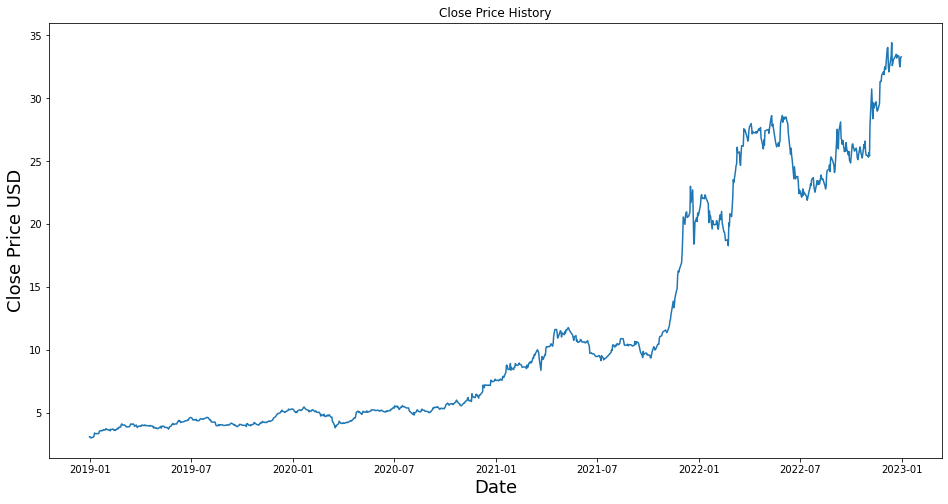

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price USD',fontsize = 18)
plt.show()

In [ ]:
time = np.arange(4 * 365 + 1)
series = df["Close"]

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(0.0001, 0.1, 0.0, 30.0)

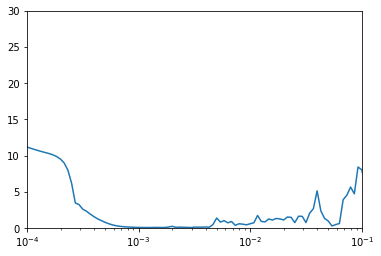

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size =128)
valid_set = seq2seq_window_dataset(x_valid,window_size , batch_size = 128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [None,1]))

for dilation_rate in (1,2,4,8,16,32):
  model.add(
      keras.layers.Conv1D(
          filters = 32,
          kernel_size = 2,
          strides= 1,
          dilation_rate = dilation_rate,
          padding = "causal",
          activation = "relu"

      )
  )

model.add(keras.layers.Conv1D(filters = 1,kernel_size = 1))

optimizer = keras.optimizers.Adam(lr = 1e-3)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5",save_best_only = True
)

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

history = model.fit(train_set,epochs = 500,
                    validation_data = valid_set,
                    callbacks = [early_stopping,model_checkpoint])


In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
cnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

<ipython-input-56-9f998b3e817d>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)


31/31 [==============================] - 1s 11ms/step


ValueError: ignored

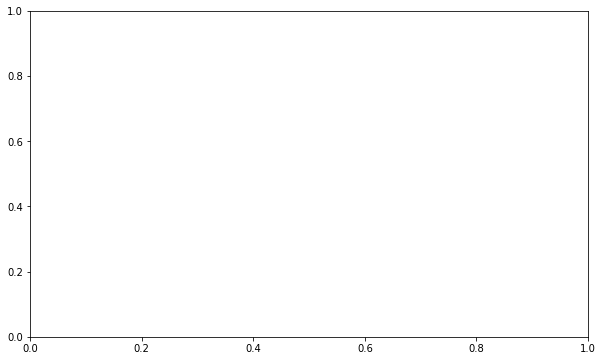

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

0.4040045

In [ ]:
import numpy as np

# Matris boyutları
x, y, z = 10, 10, 10

# Sıfırlardan oluşan matris oluştur
matrix = np.zeros((x, y, z))

# Matrisin orta noktasını hesapla
center = (x//2, y//2, z//2)

# Yarıçapı 3 olan bir silindir oluştur
radius = 3
for i in range(x):
    for j in range(y):
        for k in range(z):
            if (i-center[0])**2 + (j-center[1])**2 + (k-center[2])**2 <= radius**2:
                matrix[i,j,k] = 1
                
print(matrix)
